## О блокноте

Поводом для этой работы стал разговор с [Александром Червовым](https://www.kaggle.com/alexandervc), в ходе которого возникла идея поработать с биологической тематикой по аналогии с блокнотом "[Философия на графах](https://www.kaggle.com/visualcomments/philosophy-ru-on-graphs)". 

Мы используем слова - символьные записи генов - как имена вершин в графе, которые соединены рёбрами на основе семантического сходства между словами. Эмбеддинги слов являются источником для информации о сходстве, а граф позволяет работать с данными с применением аппарата комбинаторики и особенно теории графов.

Соавтор кода: Алексей Морозов.

## Как готовился датасет

Для датасета использовался корпус книг [Либгена](http://libgen.rs/repository_torrent/) по состоянию на сентябрь 2021 года.

Была произведена полнотекстовая индексация корпуса с помощью утилиты [recoll](https://www.lesbonscomptes.com/recoll/). Это позволяет собирать датасет по нужному запросу.

Для этого блокнота были обучены две word2vec-модели.

Первая модель (gl_model) обучена на корпусе из 1097 текстов по запросу "glioblastoma cancer cell brain tumor".

Вторая модель (al_model) обучена на корпусе из 1332 текстов по запросу "Alzheimer's disease".

## Загружаем данные

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/biology-on-graphs-w2v/al_source_list.txt
/kaggle/input/biology-on-graphs-w2v/al_model.model.trainables.syn1neg.npy
/kaggle/input/biology-on-graphs-w2v/gl_source_list.txt
/kaggle/input/biology-on-graphs-w2v/al_model.model
/kaggle/input/biology-on-graphs-w2v/gl_model.model.wv.vectors.npy
/kaggle/input/biology-on-graphs-w2v/genes_human_58347_used_in_sciPlex2_brief_info_by_mygene_package.csv
/kaggle/input/biology-on-graphs-w2v/al_model.model.wv.vectors.npy
/kaggle/input/biology-on-graphs-w2v/gl_model.model.trainables.syn1neg.npy
/kaggle/input/biology-on-graphs-w2v/gl_model.model


In [2]:
from gensim.models import Word2Vec
import gensim

In [3]:
gl_model = Word2Vec.load('/kaggle/input/biology-on-graphs-w2v/gl_model.model')
al_model = Word2Vec.load('/kaggle/input/biology-on-graphs-w2v/al_model.model')

## Смотрим данные

Проверяем количество слов в словарях моделей.

In [4]:
len(gl_model.wv.key_to_index)

1543939

In [5]:
len(al_model.wv.key_to_index)

1894207

Мы можем уточнить, есть ли нужное нам слово в словаре.

In [6]:
print('fgf20' in gl_model.wv.key_to_index)

True


In [7]:
print('fgf20' in al_model.wv.key_to_index)

True


Загружаем датасет с названиями генов.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [9]:
df = pd.read_csv('/kaggle/input/biology-on-graphs-w2v/genes_human_58347_used_in_sciPlex2_brief_info_by_mygene_package.csv')

Отсортируем строки по упоминаниям генов в PubMed.

In [10]:
df_sort = df.sort_values(by=['count pubmed'], ascending=False)
df_sort.shape

(58347, 17)

Теперь составим список слов для имён вершин в графе. Возьмем только те слова, которые есть в словарях обеих моделей.

In [11]:
words = list(df_sort['symbol'].str.lower())

In [12]:
words = [words[i] for i in range(len(words)) if (words[i] in gl_model.wv.key_to_index) and (words[i] in al_model.wv.key_to_index)]
len(words)

7901

При необходимости можем взять ограниченное количество топовых слов.

In [13]:
words = words[:1000]

Теперь создадим словари для всех пар слов обеих моделей с указанием коэффициента сходства.

Словарь из эмбеддингов gl_model:

In [14]:
dct_names = dict.fromkeys(words)
for key in dct_names.keys():
    dct_names[key] = dict.fromkeys(words);

for key1 in dct_names.keys():
    for key2 in dct_names[key1].keys():
        if key1 == key2:
            dct_names[key1][key2] = '-';        
        else:
            dct_names[key1][key2] = gl_model.wv.similarity(key1, key2)

Словарь из эмбеддингов  al_model:

In [15]:
dct_vls = dict.fromkeys(words)
for key in dct_vls.keys():
    dct_vls[key] = dict.fromkeys(words);

for key1 in dct_vls.keys():
    for key2 in dct_vls[key1].keys():
        if key1 == key2:
            dct_vls[key1][key2] = '-';        
        else:
            dct_vls[key1][key2] = al_model.wv.similarity(key1, key2)

Теперь построим граф из выбранных слов, взвешенные рёбра в котором генерируются на базе порогового значения сходства между словами.

In [16]:
import networkx as nx

Граф из эмбеддингов gl_model:

In [17]:
G_gl = nx.Graph()
G_gl.add_nodes_from(words)

for key1 in dct_names.keys():
    for key2 in dct_names[key1].keys():
        if key1 != key2:
            if dct_names[key1][key2] > 0.6:
                G_gl.add_weighted_edges_from([(key1, key2, dct_names[key1][key2])])

Граф из эмбеддингов al_model:

In [18]:
G_al = nx.Graph()
G_al.add_nodes_from(words)

for key1 in dct_vls.keys():
    for key2 in dct_vls[key1].keys():
        if key1 != key2:
            if dct_vls[key1][key2] > 0.6:
                G_al.add_weighted_edges_from([(key1, key2, dct_vls[key1][key2])])

При необходимости убираем изолированные вершины.

In [19]:
#G_gl.remove_nodes_from(list(nx.isolates(G_gl)))
#G_al.remove_nodes_from(list(nx.isolates(G_al)))

Также при необходимости выбираем в качестве графа подграф (например, гигантскую компоненту) с присутствием в нём имени топового гена.

In [20]:
#G_gl = G_gl.subgraph(nx.shortest_path(G_gl.to_undirected(),'tp53'))
#G_al = G_al.subgraph(nx.shortest_path(G_al.to_undirected(),'tp53'))

Смотрим характеристики графов: число вершин и рёбер, средняя степень:

In [21]:
print(nx.info(G_gl))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2159
Average degree:   4.3180


In [22]:
print(nx.info(G_al))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 14813
Average degree:  29.6260


Чтобы сравнить графы на семантическое подобие, посмотрим на список ближайших соседей выбранной вершины.

In [23]:
[n for n in G_gl.neighbors('tp53')]

['kras', 'pten', 'cdkn2a', 'ctnnb1', 'pik3ca', 'rb1']

In [24]:
[n for n in G_al.neighbors('tp53')]

['brca1',
 'kras',
 'braf',
 'pten',
 'cdkn2a',
 'ctnnb1',
 'brca2',
 'cdh1',
 'cdkn1a',
 'ccnd1',
 'pik3ca',
 'mlh1',
 'cdkn1b',
 'rb1',
 'idh1',
 'msh2',
 'casp8',
 'npm1',
 'chek2',
 'smad4',
 'fgfr2',
 'hras',
 'fgfr1',
 'nras',
 'ptpn11',
 'stk11',
 'fgfr3',
 'pdgfra',
 'dnmt3a',
 'cdkn2b',
 'idh2',
 'tet2',
 'tsc2',
 'msh6',
 'ptch1',
 'pkd1',
 'palb2',
 'sdhb',
 'tsc1']

В целях уточнения деталей можем найти наикратчайший путь между интересующими нас вершинами:

In [25]:
print(nx.shortest_path(G_gl,source='tp53',target='ptgs2', weight='weight'))

['tp53', 'pten', 'tgfbr2', 'tgfb2', 'ptgs2']


In [26]:
print(nx.shortest_path(G_al,source='tp53',target='ptgs2', weight='weight'))

['tp53', 'cdkn2b', 'ptgs2']


## Сообщества

Если мы хотим посмотреть, на какие группы можно разделить выбранные слова, применяются алгоритмы модульности, которые "разбивают" граф на связные компоненты-модули. Попробуем часто применяемый для этих целей алгоритм Louvain.

In [27]:
from community import community_louvain

In [28]:
communities_gl =community_louvain.best_partition(G_gl)
communities_al =community_louvain.best_partition(G_al)

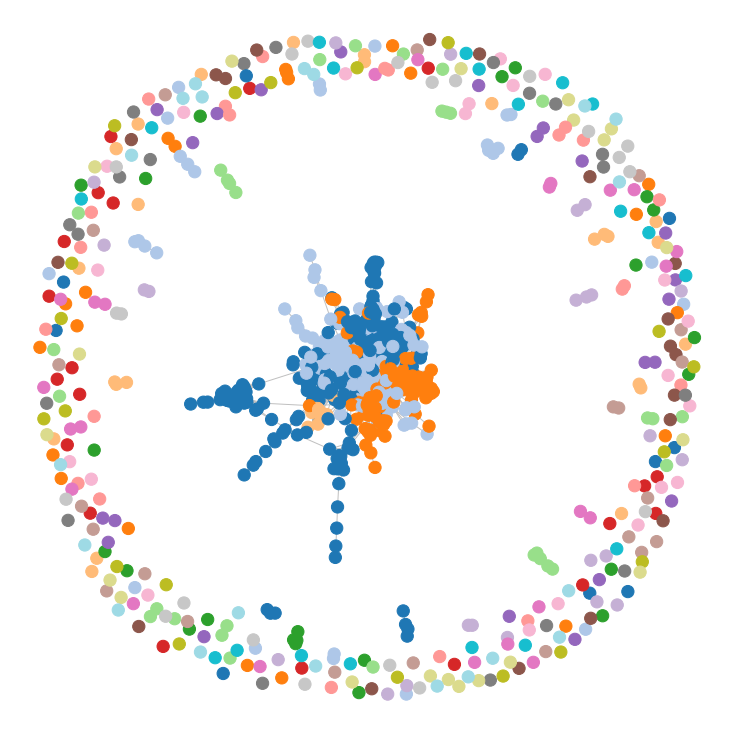

In [29]:
gl_community_id = [communities_gl[node] for node in G_gl.nodes()]

fig = plt.figure(figsize=(10, 10))
nx.draw(
    G_gl,
    #with_labels=True,
    edge_color=['silver'] * len(G_gl.edges()),
    cmap=plt.cm.tab20,
    node_color=gl_community_id,
    node_size=150,
)

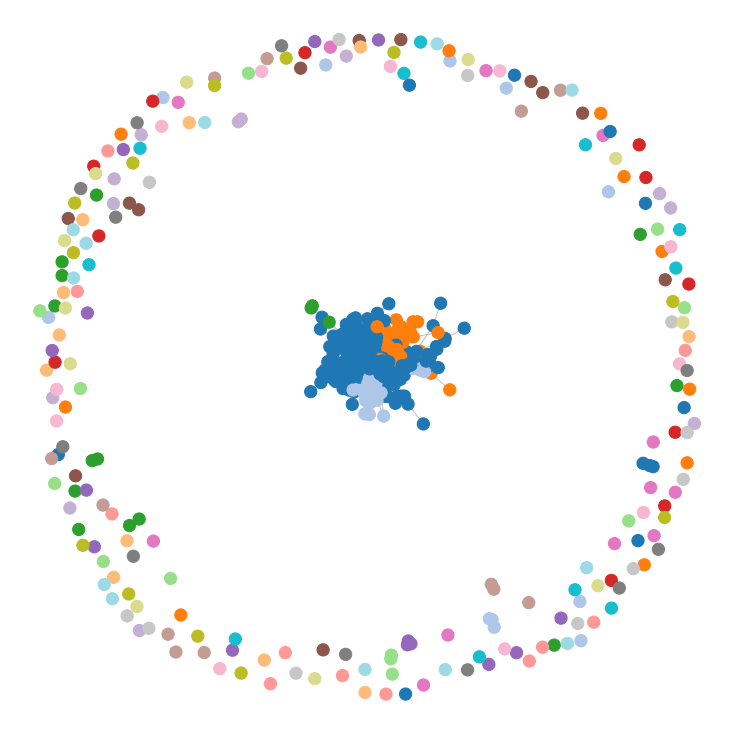

In [30]:
al_community_id = [communities_al[node] for node in G_al.nodes()]

fig = plt.figure(figsize=(10, 10))
nx.draw(
    G_al,
    #with_labels=True,
    edge_color=['silver'] * len(G_al.edges()),
    cmap=plt.cm.tab20,
    node_color=al_community_id,
    node_size=150,
)

Сохраняем идентификаторы модулей в датафреймы и смотрим содержание модулей:

In [31]:
gl_community_list = pd.DataFrame(np.column_stack([G_gl.nodes, gl_community_id]), 
                               columns=['node', 'community'])

gl_community_list.community = gl_community_list.community.astype(int)
gl_community_list.community.value_counts()

27     115
57      78
45      66
3       53
37      50
      ... 
156      1
154      1
153      1
152      1
15       1
Name: community, Length: 390, dtype: int64

In [32]:
gl_community_list_filter = gl_community_list[gl_community_list['community'] == 0]
gl_community_list_filter.head(10)

,node,community
0,tp53,0
2,egfr,0
14,akt1,0
16,erbb2,0
22,kras,0
25,braf,0
30,pten,0
32,cdkn2a,0
35,ctnnb1,0
64,pik3ca,0


In [33]:
al_community_list = pd.DataFrame(np.column_stack([G_al.nodes, al_community_id]), 
                               columns=['node', 'community'])

al_community_list.community = al_community_list.community.astype(int)
al_community_list.community.value_counts()

0     201
3     194
15    137
31    118
8     105
     ... 
95      1
96      1
97      1
98      1
27      1
Name: community, Length: 226, dtype: int64

In [34]:
al_community_list_filter = al_community_list[al_community_list['community'] == 0]
al_community_list_filter.head(10)

,node,community
0,tp53,0
2,egfr,0
15,brca1,0
19,nfkb1,0
22,kras,0
25,braf,0
30,pten,0
32,cdkn2a,0
35,ctnnb1,0
40,brca2,0


Сравниваем графы по кластерам:

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(al_community_list.community, gl_community_list.community)

0.08719935802017809

## Меры центральности

Для ранжирования вершин в графе можно воспользоваться мерами центральности.

Собственный вектор:

In [36]:
def eigenvector(G_gl):
    ev = nx.eigenvector_centrality(G_gl)
    df = pd.DataFrame.from_dict({
        'node': list(ev.keys()),
        'eigenvector_gl': list(ev.values())
    })
    return df.sort_values('eigenvector_gl', ascending=False)

eigenv_gl = pd.DataFrame(eigenvector(G_gl), columns=['node', 'eigenvector_gl'])
eigenv_gl.head(10)

,node,eigenvector_gl
747,grin2b,0.238821
382,itgb2,0.238666
737,arrb2,0.228614
900,il6st,0.220384
834,dtnbp1,0.218896
768,pon2,0.218365
876,mir140,0.216679
979,ctnnd1,0.202310
880,ppia,0.200429
325,hsp90aa1,0.200283


In [37]:
def eigenvector(G_al):
    ev = nx.eigenvector_centrality(G_al)
    df = pd.DataFrame.from_dict({
        'node': list(ev.keys()),
        'eigenvector_al': list(ev.values())
    })
    return df.sort_values('eigenvector_al', ascending=False)

eigenv_al = pd.DataFrame(eigenvector(G_al), columns=['node', 'eigenvector_al'])
eigenv_al.head(10)

,node,eigenvector_al
677,sumo1,0.130145
19,nfkb1,0.127161
365,thbs1,0.121735
724,ctsb,0.119000
147,casp3,0.118514
303,tnfrsf1b,0.113046
896,kitlg,0.108492
101,itgb3,0.107522
536,tnfrsf10b,0.106758
794,cldn1,0.106190


Пейджранк:

In [38]:
def pr_summary(G_gl):
    pr = nx.pagerank(G_gl)
    df = pd.DataFrame.from_dict({
        'node': list(pr.keys()),
        'centrality_pr_gl': list(pr.values())
    })
    return df.sort_values('centrality_pr_gl', ascending=False)

pr_gl = pd.DataFrame(pr_summary(G_gl), columns=['node', 'centrality_pr_gl'])
pr_gl.head(10)

,node,centrality_pr_gl
747,grin2b,0.007775
900,il6st,0.005869
989,sox4,0.005352
844,ednrb,0.005137
849,cacna1a,0.004825
618,tgfb2,0.004741
382,itgb2,0.004655
628,stat4,0.004325
19,nfkb1,0.004184
33,ptgs2,0.004060


In [39]:
def pr_summary(G_al):
    pr = nx.pagerank(G_al)
    df = pd.DataFrame.from_dict({
        'node': list(pr.keys()),
        'centrality_pr_al': list(pr.values())
    })
    return df.sort_values('centrality_pr_al', ascending=False)

pr_al = pd.DataFrame(pr_summary(G_al), columns=['node', 'centrality_pr_al'])
pr_al.head(10)

,node,centrality_pr_al
19,nfkb1,0.006186
147,casp3,0.006119
327,tgfbr2,0.006097
446,socs1,0.005926
58,cdkn1a,0.005711
724,ctsb,0.004931
980,irak1,0.004896
35,ctnnb1,0.004806
677,sumo1,0.004473
264,il12b,0.004437


Центральность по посредничеству:

In [40]:
def bc_summary(G_gl):
    bc = nx.betweenness_centrality(G_gl)
    df = pd.DataFrame.from_dict({
        'node': list(bc.keys()),
        'centrality_bc_gl': list(bc.values())
    })
    return df.sort_values('centrality_bc_gl', ascending=False)

bc_gl = pd.DataFrame(bc_summary(G_gl), columns=['node', 'centrality_bc_gl'])
bc_gl.head(10)

,node,centrality_bc_gl
747,grin2b,0.073559
618,tgfb2,0.035672
844,ednrb,0.031450
322,mefv,0.026301
116,slc6a3,0.024037
19,nfkb1,0.023186
327,tgfbr2,0.023026
238,apex1,0.021825
8,il10,0.021700
376,ephx1,0.020011


In [41]:
def bc_summary(G_al):
    bc = nx.betweenness_centrality(G_al)
    df = pd.DataFrame.from_dict({
        'node': list(bc.keys()),
        'centrality_bc_al': list(bc.values())
    })
    return df.sort_values('centrality_bc_al', ascending=False)

bc_al = pd.DataFrame(bc_summary(G_al), columns=['node', 'centrality_bc_al'])
bc_al.head(10)

,node,centrality_bc_al
58,cdkn1a,0.025840
147,casp3,0.024446
19,nfkb1,0.023986
327,tgfbr2,0.023274
446,socs1,0.020278
677,sumo1,0.017618
9,esr1,0.017159
980,irak1,0.016935
724,ctsb,0.016763
747,grin2b,0.015083


Объединяем все коэффициенты в один датафрейм:

In [42]:
df_sort['symbol'] = df_sort['symbol'].str.lower()
df_sort['node'] = df_sort['symbol']
df_node = df_sort[['node', 'count pubmed']]

In [43]:
from functools import reduce

dfs = [df_node, eigenv_gl, eigenv_al, pr_gl, pr_al, bc_gl, bc_al]  
df_sum = reduce(lambda left,right: pd.merge(left,right,on='node'), dfs)

Отсортируем по частоте упоминаний в PubMed:

In [44]:
df_sum_sort = df_sum.sort_values(by=['count pubmed'], ascending=False)
df_sum_sort.head(10)

,node,count pubmed,eigenvector_gl,eigenvector_al,centrality_pr_gl,centrality_pr_al,centrality_bc_gl,centrality_bc_al
0,tp53,9466.0,3.889108e-05,1.359711e-02,0.001651,0.001431,0.001731,0.002093
1,tnf,6250.0,4.157446e-33,2.657543e-54,0.000210,0.000183,0.000000,0.000000
2,egfr,5535.0,5.969468e-07,2.533760e-04,0.001259,0.000290,0.004493,0.000004
3,apoe,5003.0,4.157446e-33,2.657543e-54,0.000210,0.000183,0.000000,0.000000
4,il6,4966.0,1.370179e-03,2.248437e-02,0.001579,0.002014,0.004877,0.002285
5,vegfa,4847.0,8.053914e-04,5.159565e-02,0.002347,0.002361,0.006796,0.002932
6,tgfb1,4582.0,5.780645e-03,6.339240e-02,0.002698,0.003859,0.011939,0.010156
7,mthfr,4373.0,4.241694e-06,1.549775e-03,0.001396,0.001351,0.014243,0.000977
8,il10,3423.0,2.868886e-03,1.190226e-02,0.003391,0.001206,0.021700,0.000215
9,esr1,3187.0,2.758636e-03,6.391868e-02,0.001704,0.004291,0.002666,0.017159


In [45]:
corr = df_sum.corr(method='spearman', min_periods=1)
corr.style.background_gradient(cmap='coolwarm')

,count pubmed,eigenvector_gl,eigenvector_al,centrality_pr_gl,centrality_pr_al,centrality_bc_gl,centrality_bc_al
count pubmed,1.000000,0.062779,-0.006335,0.136445,0.101999,0.141541,0.134036
eigenvector_gl,0.062779,1.000000,0.373317,0.758143,0.353334,0.704954,0.349141
eigenvector_al,-0.006335,0.373317,1.000000,0.285185,0.873233,0.326395,0.781218
centrality_pr_gl,0.136445,0.758143,0.285185,1.000000,0.389959,0.783918,0.379489
centrality_pr_al,0.101999,0.353334,0.873233,0.389959,1.000000,0.384508,0.881902
centrality_bc_gl,0.141541,0.704954,0.326395,0.783918,0.384508,1.000000,0.402722
centrality_bc_al,0.134036,0.349141,0.781218,0.379489,0.881902,0.402722,1.000000


## Классификация термов

В результате разбиения графа на сообщества у нас есть размеченный датасет. Если сообщества (модули) хорошо интерпретируются, то мы можем использовать значения векторов слов как признаки (фичи) для предсказания целевых переменных (модулей). Рассмотрим пример с мультиклассификацией.

Снова построим граф. Мы будем использовать граф только для вычислительных целей, поэтому возьмём любые положительные значения коэффициента сходства между словами для построения взвешенных рёбер между вершинами.

In [46]:
g = nx.Graph()
g.add_nodes_from(words)

for key1 in dct_names.keys():
    for key2 in dct_names[key1].keys():
        if key1 != key2:
            if dct_names[key1][key2] > 0:
                g.add_weighted_edges_from([(key1, key2, dct_names[key1][key2])])

In [47]:
communities =community_louvain.best_partition(g)

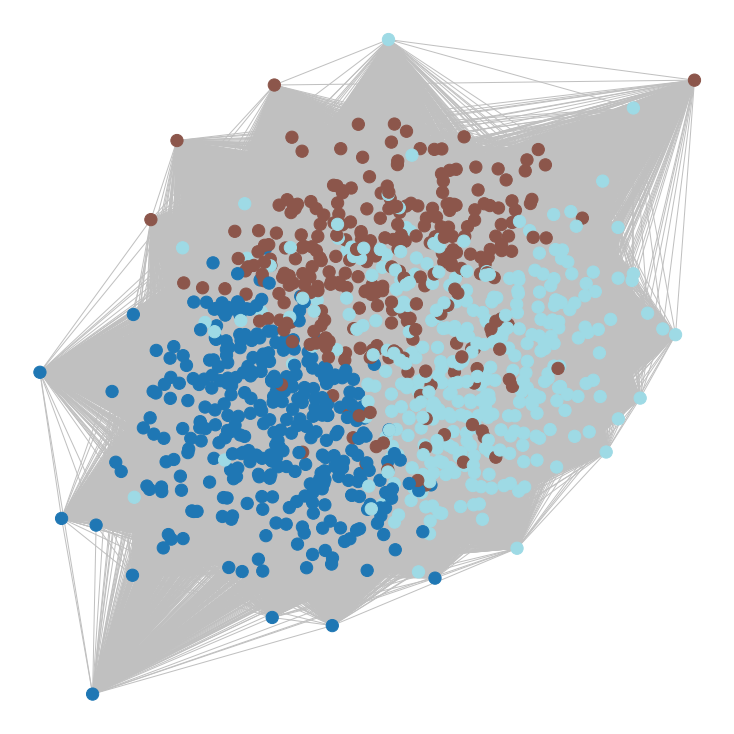

In [48]:
community_id = [communities[node] for node in g.nodes()]

fig = plt.figure(figsize=(10, 10))
nx.draw(
    g,
    #with_labels=True,
    edge_color=['silver'] * len(g.edges()),
    cmap=plt.cm.tab20,
    node_color=community_id,
    node_size=150,
)

In [71]:
community_list = pd.DataFrame(np.column_stack([g.nodes, community_id]), 
                               columns=['node', 'community'])

community_list.community = community_list.community.astype(int)
community_list['community'].value_counts()

2    361
0    344
1    295
Name: community, dtype: int64

In [50]:
df_target = community_list.copy()

In [51]:
x = [(gl_model.wv[str(i)]) for i in df_target['node']]

In [52]:
emb_df_untarget = pd.DataFrame(x, index = df_target['node'])

In [53]:
df_target.set_index('node', inplace=True)

In [54]:
emb_df_target = df_target.join(emb_df_untarget)

In [55]:
df_train = emb_df_target

In [56]:
data_full = df_train.copy()
X_data = data_full.drop('community', axis=1)
y = data_full.community

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [58]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_data, label_encoded_y,test_size=test_size, random_state=seed)
xgb = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
xgb.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.8, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.800000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.5,
              reg_lambda=0.5, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
predictions = xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.97%


Теперь мы можем предсказать целевые значения на новом наборе слов.

In [60]:
pred_words = [

    'bevacizumab',
    'valdecoxib',
    'etoricoxib',
    'alirocumab',
    'linagliptin',
    'apixaban',
    'alectinib',
    'sofosbuvir',
    'bevirimat',
    'ivacaftor',
    'vilanterol',
    'evolocumab',
    'tisagenlecleucel',
    'leflunomide',
    'ropivacaine',
    'eletriptan',
    'lopinavir',
    'parecoxib',
    'rofecoxib',
    'celecoxib',
    'ketoprofen',
    'ketorolac',
    'ondansetron',
    'sumatriptan',
    'salmeterol',
    'verapamil',
    'tramadol',
    'propofol',
    'ranitidine',
    'naproxen',
    'carfentanil',    
    'budesonide',
    'diclofenac',
    'etidocaine',
    'mupirocin',
    'cimetidine',
    'metolazone',
    'ciclosporin',
    'prilocaine',
    'amiloride',
    'salbutamol'     

]

In [61]:
pred_words = [pred_words[i] for i in range(len(pred_words)) if (pred_words[i] in gl_model.wv.key_to_index) and (pred_words[i] in al_model.wv.key_to_index)]

In [62]:
len(pred_words)

41

In [63]:
x1 = [(gl_model.wv[str(i)]) for i in pred_words]

In [64]:
emb_df = pd.DataFrame(x1, index = pred_words)

In [65]:
boosted_predictions = xgb.predict(emb_df)

In [66]:
node = emb_df.index

In [67]:
pred_results = pd.DataFrame({'node': node, 'value_prediction': boosted_predictions})
pred_results.value_prediction.value_counts()

0    25
2    14
1     2
Name: value_prediction, dtype: int64

In [68]:
select_class = pred_results.loc[pred_results['value_prediction'] == 1]
select_class

,node,value_prediction
23,sumatriptan,1
29,naproxen,1


In [69]:
community_list_filter = community_list[community_list['community'] == 1]
community_list_filter.head(10)

,node,community
0,tp53,1
3,apoe,1
7,mthfr,1
9,esr1,1
11,ace,1
15,brca1,1
20,gstm1,1
22,kras,1
23,abcb1,1
25,braf,1
